#Introduction to Pytorch
This assignment investigates the use of the pytorch framework for deep learing.

* Pytorch allows support for multidimensional arrays - [tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html) (which is the core data type) that are used in the computation required for deep learning. (Tensors are similar to numpy arrays, a numpy array (e.g. image) can be converted to a tensor.)

* Pytorch uses a graph based structure to represent a neural network. The network nodes consist of operations (e.g. multiplication or other function) and the edges are tensors (the result of operations). Pytorch supports common neural network layers & functions allowing the graph to be assembled quickly (avoiding coding for every multiplication etc).

* A key feature of Pytorch is that it can also perform automatic differentiation across the graph. This operation is required to perform back propagation, which obtains gradients (needed for optimisation) with respect to the loss function.

* Pytorch also supports various optimiation algorithms that update the weights of the network based on the learning rate. Pytorch also supports various learning rate schedules that can improve the final accuracy.

Often students will first encounter tensorflow as their first deep learing framework. Tensorflow adopts the high level keras API which abstracts the training to a single command (which has limitations). In contrast pytorch does not have high level API (see note 2 below) therefore low level operations much be coded. For example a training loop is required to be constructed. This training loop requires key steps such as back propagation and optimiser updates to be carried out. Importantly pytorch (in contrast to high level APIs) gives flexibility to implement training for any network. (Tensorflow does have the same low level functionality as pytorch but it is less widely used in deep learing research community)

In this lab you will cover the basics of using pytorch.

* Construct a dataloader to import a dataset.
* Construct a simple neural network model.
* Construct a training and evaluation loop.
* Train the network.

(Note 1: **The focus of this lab is on understanding how to use pytorch rather than on achieving the best performance with network**. Optimising the training procedure is the focus of the next lab. So there is no need in this lab to include data augmentation, regualrisation techniques or learning rate scheduler. Assessment of this lab will be based on properly writing the key functions/classes.)

(Note 2: A package called [pytorch lightening](https://lightning.ai/) has been developed to bring high level abstraction to pytorch (similar to keras with tensorflow). However the risk of using packages with high level abstractions (or APIs), such as pytorch lightening or the hugging face API is that these APIs may greatly restrict flexibility to re-use a deep learing model or adapt training the etc. If coded in basic pytorch there will not be any issues!)

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is a dataset with small size (32x32) images and 50k training samsamples.
* It is often used as a "Hello World" type data set to setup a training pipeline. As is relatively fast to train a network with CIFAR-10, this dataset is also widely used for running comparison or optimisation experiments. For example comparing different networks, regularisation methods or optimisers. (In pytorch the CIFAR-10 dataset is available as a [pytorch dataset](https://pytorch.org/vision/0.18/generated/torchvision.datasets.CIFAR10.html) simplifying loading the dataset.)




In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, v2, Pad
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [7]:
!pip install torchinfo

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


## 1. Dataset and Dataloader

Pytorch uses a [Dataset class](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) which allows creation of datasets for various data structures (e.g. set of images/labels). The (Map style) dataset stores samples/labels and can return a dataset sample based on an index e.g. `dataset[idx]`.

The [torchvision](https://pytorch.org/vision/stable/index.html) package (imported above) makes available several common image classification, object detection, semantic segmentation datasets, aswell as other [datasets](https://pytorch.org/vision/stable/datasets.html) for common computer vision applications.
* For this assignment you can load the cifar 10 dataset.

An important step in pytorch datasets is the use of [transforms](https://pytorch.org/vision/main/transforms.html), these are commonly used to normalise data, convert to floating point or other datatype and apply data augmentation and finally to convert the dataset samples (e.g. numpy array) to a tensor.
* The simple transform to convert dataset images to tensors can be seen in the [datset & dataloader tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#loading-a-dataset).

The [pytorch dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class provides a python iterable which can be later used in the training loop to return a batch of images (and corresponding labels) on each iteration of the training loop. If required the dataloader can use different sampling strategies or shuffle the data.
* The basic use of a DataLoader can be seen [in the pytorch dataset & dataloader tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)

(Just to note that both the Dataset and DataLoader are classes, so when you create a dataset (you will have both training and test datasets) and dataloader you will be creating a python object.)


In the code cell below create instances of training and test datasets (from the [pytorch CIFAR-10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10) dataset).
Simple [transforms](https://pytorch.org/vision/main/transforms.html) should be included to convert to floating point 32, Normalise the data to the range [0,1] and convert to a tensor. (There is no need to include data augmentation, so the same transform can be used for training and test data)

In [9]:
# Create instances of training and test datasets here

# Define transformations: Convert to float32 and then normalize to [0,1], and convert to tensor
transforms = transforms.Compose([
    transforms.ToTensor(),  # Converts image to tensor and scales to [0,1]
    transforms.ConvertImageDtype(torch.float32)  # Ensures float32 dtype
])

# Load CIFAR-10 dataset
training_data = datasets.CIFAR10(
    root="data", train=True, download=True, transform=transforms # Setting train=True will only get the training part of the data
)

test_data = datasets.CIFAR10(
    root="data", train=False, download=True, transform=transforms # Setting train=false will only get the testing part of the data
)

In the code cell below you can create instances of the dataloader for the train and test datasets. It is necessary to select a batch size for the images, typically the largest possible batch size is selected to increase the speed of training. The largest size is limted by the memory capacity of GPU used to train the model.

In [10]:
# Create Instances of Dataloaders

# Set batch size
batch_size = 128

# Create DataLoader instances
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

We will now check how many samples are in the datasets and batches in the dataloader.

In [11]:
print('Test Samples ',len(test_dataloader.dataset))
print('Train Samples ',len(train_dataloader.dataset))
print('Test Batches ',len(test_dataloader))
print('Train Batches ',len(train_dataloader))

Test Samples  10000
Train Samples  50000
Test Batches  79
Train Batches  391


We will output some sample images from the dataloader to verify it is operating correctly.

* Note the use of python `iter` and `next` that can be used with iterables (such as a dataloader).
* Pytorch uses a data format of channels first e.g. for an image size of 64,64 the iterator will return a batch with a shape [batch_size,3,32,32]. Matplotlib requires individual images to be in a format of channels last [32,32,3] so a permute operation is applied to swap the channel dimension.
* The images are re-normalised for display (They were normalised for input to the model).

In [12]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

def plot_examples(image_batch,labels_batch,pred_labels_batch):
  n_plots = 12 # number of plots
  f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

  for i, image in enumerate(image_batch[0:n_plots,:,:,:]):
    # return image to cpu for display and permute to channels last
    disp_image =  torch.permute(image.to('cpu'),(2,1,0)).numpy()

    # Correct mean/std for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    disp_image = std * disp_image + mean
    disp_image = np.clip(disp_image, 0, 1)

    #
    axarr[i].imshow(disp_image[:,:,:])
    axarr[i].axis("off")
    #predicted, actual = classes[pred_labels_batch[0,i]], classes[labels_batch[i]]
    predicted, actual = classes[pred_labels_batch.to('cpu')[i]], classes[labels_batch.to('cpu')[i]]
    color = 'black' if predicted == actual else 'red'
    axarr[i].set_title(predicted,fontsize='small', color=color)




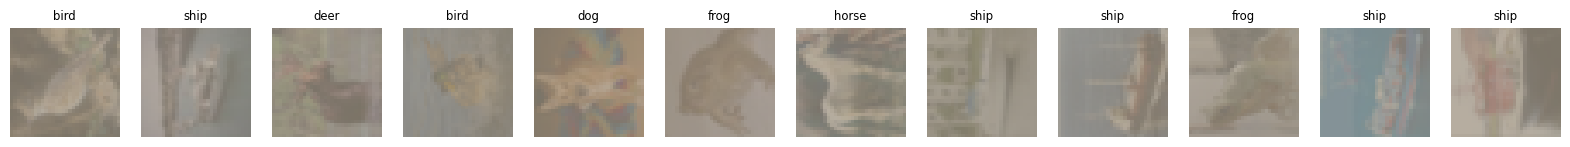

In [13]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Call plot with pred_label_batch = labels_batch before training
plot_examples(image_batch,labels_batch,labels_batch)

# 2. Define CNN Model

To define a neural network in PyTorch, we create a class that inherits ([see python inheritance](https://www.w3schools.com/python/python_inheritance.asp))
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network as a seqential model (nn.sequential) in the `__init__` function and
specify how data will pass through the network in the `forward`
function. An example is shown

In the code cell below you will construct a simple CNN using [2D convolution](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [2D max pooling layers](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html). [Relu activiation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) is applied after the convolution layers. The output of the last convolution is [flattened](https://pytorch.org/docs/stable/generated/torch.flatten.html) and [2 linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) (dense or fully connected) layers applied. Only activiation is applied after the first linear layer. As seen in the next section when setting up our loss function we use the form `_from_logits` so the optimiser will know that softmax activiation needs to be applied. (Alternatively we could directly apply [softmax activiation](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html) wihin the model, but it is more computationally efficent/stable to include the softmax within the loss function)

The code cell provides an outline of the architecture that is required. (You do not need to any additional layers such as batch normalisation or dropout to improve the regularisation of the network. We will investigate regularising training and optimising the performance of the network in the next lab)


In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.simple_cnn = nn.Sequential(
            # Convolution 2d, kernel size =3, stride =1, padding = same, No. Kernels = 32
            # ReLU activation,
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),

            # Convolution 2d, kernel size =3, stride =1, padding = same, No. Kernels = 64
            # ReLU activation,
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),

            # Maxpooling 2d, kernel size = 2
            nn.MaxPool2d(kernel_size=2),

            # Convolution 2d, kernel size =3, stride =1, padding = same, No. Kernels = 64
            # ReLU activation,
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),

            # Convolution 2d, kernel size =3, stride =1, padding = same, No. Kernels = 64
            # ReLU activation,
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),

            # Maxpooling 2d, kernel size = 2
            nn.MaxPool2d(kernel_size=2),

            # Convolution 2d, kernel size =3, stride =1, padding = same, No. Kernels = 128
            # ReLU activation,
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),

            # Convolution 2d, kernel size =3, stride =1, padding = same, No. Kernels = 256
            # ReLU activation,
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),

            # Convolution 2d, kernel size =3, stride =1, padding = same, No. Kernels = 256
            # ReLU activation,
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),

            # Maxpooling 2d, kernel size = 2
            nn.MaxPool2d(kernel_size=2),

            # Flatten
            nn.Flatten(),

            # Linear Layer, 512 neurons
            nn.Linear(4 * 4 * 256, 512),  # CIFAR-10 images are 32x32, reduced by 3 max pools

            # ReLU activation,
            # Linear Layer, 10 neurons
            nn.ReLU(),
            nn.Linear(512, 10)  # Output 10 classes (logits)
       )

    def forward(self, x):

        logits = self.simple_cnn(x)
        return logits

# # Necessary to transfer model to GPU
# Make sure your model is called model to be compatible with the evaluation part below.
model = NeuralNetwork().to(device)

We can use Torch Info to print the structure of the network we have created. The shape of the tensor after each operation is shown. This should correspind with what you expect.

In [15]:
from torchinfo import summary
# Ensure input size is correct
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─ReLU: 2-2                         [128, 32, 32, 32]         --
│    └─Conv2d: 2-3                       [128, 64, 32, 32]         18,496
│    └─ReLU: 2-4                         [128, 64, 32, 32]         --
│    └─MaxPool2d: 2-5                    [128, 64, 16, 16]         --
│    └─Conv2d: 2-6                       [128, 64, 16, 16]         36,928
│    └─ReLU: 2-7                         [128, 64, 16, 16]         --
│    └─Conv2d: 2-8                       [128, 64, 16, 16]         36,928
│    └─ReLU: 2-9                         [128, 64, 16, 16]         --
│    └─MaxPool2d: 2-10                   [128, 64, 8, 8]           --
│    └─Conv2d: 2-11                      [128, 128, 8, 8]          73,85

# 3. Optimisation & Training Loop

For this classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* The SGD (Stocasitc Gradient Descent) Optimiser is provided as a the default training configuration. We can use the default learning rate with our network.

* Make sure to run the model call and optimiser call before starting training again to ensure the previous training state is cleared.


In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In the code cell below you will complete training/validation function `train_val_loop` with sub-functions for the training and validation steps, aswell as auxillary functions to calculate and display metrics during training. (Note that this is a suggested approach and you may change if you prefer, but is recommended to try and structure the training loop in line with good coding practice (unlike the pytorch tutorials!))
* The sub-function `train_step` performs a forward pass with the model on the input batch, calculates loss, performs backpropagation and updates the optimiser. The function returns the loss and model outputs. The flag `model.train(True)` can be set to make sure training specific layers such as batch normalisation are operating in test mode. This will not be necessary for the model we are using but it is good practice to alway include it.
* These returned loss and model output can be sent to a function `calc_metrics`, this function should keep a cumulative sum of the loss over a set interval of iterations allowing average loss to be calculated. Typically we will calculate the loss and accuracy at the end of each epoch (but we can output at shorter intervals if required, e.g. with very large dataset so we can see how the training is progressing.)
* The sub-function `val_step` performs a foward pass on the model, we will calculate the validation loss, but we don't perform optimisation or update the the optimiser. For validation we also can set  model.train(False), this will disable regularisation and batch normalisation (These are not present in this model but it is good practice to use this flag). We can also use the decorator `with torch.no_grad()` which prevents uncessary gradient computation.

 As mentioned in the notebook introduction, pytorch does not have a native high level API for training. This means we have to include key steps including passing data though the model (forward pass), calculating the loss, performing the backward pass and updating the optimiser. Useful examples of training loops are detailed in the [pytorch optimisation tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) and the [pytorch transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). Although it is more laborious to construct pytorch training loops compare to tensorflow, learning to do this (and understanding the steps) will allow you to develop training loops for more complex neural networks and applications.  

Note that we are running the model (or graph) on the GPU, so it is necessary to also move the input tensors and labels to the GPU with the statement before calling the model `inputs, labels = inputs.to(device), labels.to(device)`


In [20]:
def train_step(model, dataloader, loss_fn, optimizer):
    # Steps for training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # calculate the loss for each batch of data that will help us to compute the average loss over all batches for an epoch
        _, predicted = outputs.max(1) # extracts the predicted class label for each input in the batch.
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss, correct, total


def test_step(model, dataloader, loss_fn):
    # Steps for validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): # no gradients should be computed for the operations inside this particular block
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss, correct, total


def calc_metrics(running_loss, correct, total, dataloader):
    # Determines loss and accuracy metrics
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


def train_eval_loop(n_epochs):
    # Where n_epochs is the number of epochs
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        # Enumerate over the training data
        train_loss, train_correct, train_total = train_step(model, train_dataloader, loss_fn, optimizer)

        # Call training step
        train_avg_loss, train_acc = calc_metrics(train_loss, train_correct, train_total, train_dataloader)

        # Enumerate over Test/val dataset (at end of epoch)
        test_loss, test_correct, test_total = test_step(model, test_dataloader, loss_fn)

        # Call Test step
        test_avg_loss, test_acc = calc_metrics(test_loss, test_correct, test_total, test_dataloader)

        # Calculate metrics at end of each epoch
        print(f"Epoch {epoch+1}/{n_epochs} - "
              f"Train Loss: {train_avg_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Test Loss: {test_avg_loss:.4f}, Test Acc: {test_acc:.4f}")

## 4. Run Training Loop

You can run the training over 20 Epochs, if your training loop is functional and the model is correctly constructed you should expect to achieve a training accuracy of approximatly 100 % and a test accuracy of ~78 %. The large difference between the training and test accruacy indicates the model is overfitting. (Note that you do not have to correct the overfitting in this lab, we will deal with optimising training in the next lab)

Note: Run your training loop over a single epoch initally for testing purposes.

In [21]:
n_epochs=20

train_eval_loop(n_epochs)


Epoch 1/20 - Train Loss: 2.3029, Train Acc: 0.0977 - Test Loss: 2.3025, Test Acc: 0.1000
Epoch 2/20 - Train Loss: 2.3024, Train Acc: 0.1049 - Test Loss: 2.3017, Test Acc: 0.1005
Epoch 3/20 - Train Loss: 2.1540, Train Acc: 0.1951 - Test Loss: 2.0358, Test Acc: 0.2384
Epoch 4/20 - Train Loss: 1.8210, Train Acc: 0.3192 - Test Loss: 1.6759, Test Acc: 0.3638
Epoch 5/20 - Train Loss: 1.5913, Train Acc: 0.4097 - Test Loss: 1.4571, Test Acc: 0.4600
Epoch 6/20 - Train Loss: 1.3658, Train Acc: 0.5058 - Test Loss: 1.2648, Test Acc: 0.5409
Epoch 7/20 - Train Loss: 1.1863, Train Acc: 0.5748 - Test Loss: 1.1653, Test Acc: 0.5847
Epoch 8/20 - Train Loss: 1.0231, Train Acc: 0.6357 - Test Loss: 1.0808, Test Acc: 0.6182
Epoch 9/20 - Train Loss: 0.9024, Train Acc: 0.6798 - Test Loss: 0.9621, Test Acc: 0.6617
Epoch 10/20 - Train Loss: 0.7941, Train Acc: 0.7206 - Test Loss: 0.8222, Test Acc: 0.7146
Epoch 11/20 - Train Loss: 0.6897, Train Acc: 0.7577 - Test Loss: 0.8061, Test Acc: 0.7175
Epoch 12/20 - Train

# 5. Evaluate Model
We will obtain the classification report after final evaluation of the test dataset with the model. A confusion matrix can also be obtained and we will plot a few example images.

In [22]:
import numpy as np
import matplotlib.pyplot as plt



store_predictions = []
store_labels = []
model.eval()

# Evaluation loop to produce predictions for use with scikit learn confusion matrix
def eval_loop(test_dataloader):

   num_test_batches = len(test_dataloader)
   for i, data in enumerate(test_dataloader, 0):
      # basic test loop
      input_batch, label_batch = data
      input_batch = input_batch.to(device)

      pred_logit = model(input_batch)
      predictions = torch.argmax(pred_logit,1) # reduce along output dimension
      predictions_np = predictions.to("cpu").numpy()
      label_batch_np = label_batch.numpy()
      if i<num_test_batches-1:
        store_predictions.append(predictions_np)
        store_labels.append(label_batch)

   y_pred = np.squeeze(np.reshape(store_predictions,(1,(num_test_batches-1)*batch_size)))
   y_true = np.squeeze(np.reshape(store_labels,(1,(num_test_batches-1)*batch_size)))
   return y_pred, y_true

y_pred, y_true = eval_loop(test_dataloader)

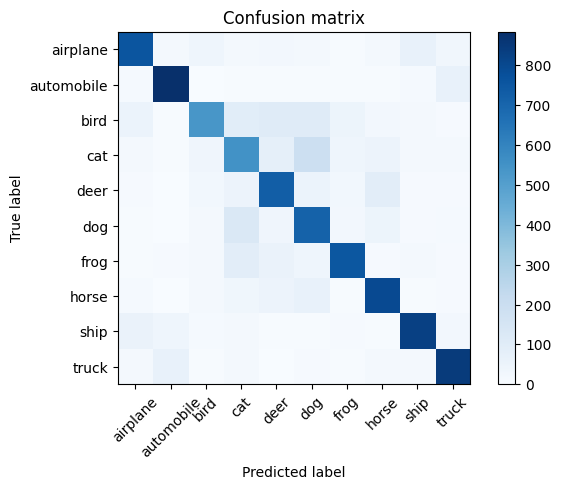

In [23]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.80      0.76      0.78       998
  automobile       0.85      0.88      0.87       999
        bird       0.76      0.54      0.63       999
         cat       0.55      0.55      0.55       997
        deer       0.67      0.73      0.70      1000
         dog       0.59      0.72      0.65       997
        frog       0.82      0.75      0.78      1000
       horse       0.75      0.80      0.77       997
        ship       0.83      0.83      0.83       997
       truck       0.82      0.84      0.83      1000

    accuracy                           0.74      9984
   macro avg       0.74      0.74      0.74      9984
weighted avg       0.74      0.74      0.74      9984



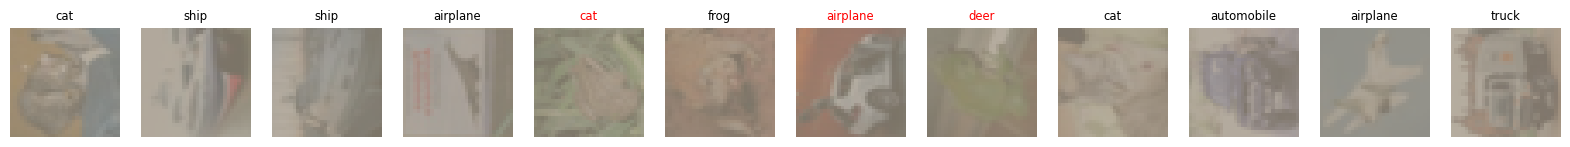

In [25]:
# Output next batch from dataloader
dataiter = iter(test_dataloader)
image_batch, labels_batch = next(dataiter)

# Pass batch through model
model.eval()
image_batch = image_batch.to(device)
pred_logit = model(image_batch)
pred_labels_batch = torch.argmax(pred_logit,1)

# Use plot examples function
plot_examples(image_batch,labels_batch,pred_labels_batch)


